# 8-11. 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
이전 스텝까지는 영문 텍스트의 감정 분석을 진행해 보았습니다. 그렇다면 이번에는 한국어 텍스트의 감정 분석을 진행해 보면 어떨까요? 오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus입니다.

데이터 다운로드 없이 Cloud shell에서 해당 파일의 심볼릭 링크를 연결해 주세요

- ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

## 라이브러리 버전을 확인해 봅니다
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import pandas
import konlpy
import gensim

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


## 1) 데이터 준비와 확인


In [2]:
import pandas as pd

# 데이터를 읽어오기(train & test)
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

## 2) 데이터로더 구성
실습 때 다루었던 IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메서드를 호출하면 숫자 인덱스로 변환된 텍스트와 word_to_index 딕셔너리까지 친절하게 제공합니다. 그러나 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있습니다. 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작합니다. data_loader 안에서는 다음을 수행해야 합니다.
- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [3]:
from konlpy.tag import Mecab
import numpy as np
import tensorflow as tf
import os

from collections import Counter

tokenizer = Mecab()
# 불용어(Stopwords) 리스트
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2

index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3) 모델 구성을 위한 데이터 분석 및 가공
- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 데이터셋 내 문장 길이 분포 & 적절한 최대 문장 길이 지정

In [6]:
total_data_text = list(X_train) + list(X_test)
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)

print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens) * 100))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 93.42988343341575%가 maxlen 설정값 이내에 포함됩니다. 


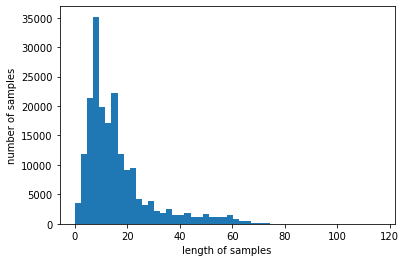

In [7]:
import matplotlib.pyplot as plt

# 문장 길이 분포 확인
plt.hist([review for review in num_tokens], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

### keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

In [8]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(146182, 41)


## 4) 모델 구성 및 validation set 구성
모델은 3가지 이상 다양하게 구성하여 실험해 보세요.

### 1. LSTM

In [9]:
# validation set 30000건 분리
X_val = X_train[:30000]   
y_val = y_train[:30000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[30000:]  
partial_y_train = y_train[30000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(116182, 41)
(116182,)


In [10]:
vocab_size = 10000
word_vector_dim = 100
embedding_dim = 100
hidden_units = 128

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim))
model.add(tf.keras.layers.LSTM(hidden_units))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         1000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


### 2. RNN

In [11]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

### 3. CNN

In [12]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.MaxPooling1D(5))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 16)          11216     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 16)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                

## 5) 모델 훈련 개시


In [13]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 35s 6ms/step - loss: 0.3810 - accuracy: 0.8301 - val_loss: 0.3309 - val_accuracy: 0.8530
Epoch 2/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.3140 - accuracy: 0.8666 - val_loss: 0.3120 - val_accuracy: 0.8646
Epoch 3/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2890 - accuracy: 0.8787 - val_loss: 0.3051 - val_accuracy: 0.8683
Epoch 4/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2725 - accuracy: 0.8873 - val_loss: 0.3071 - val_accuracy: 0.8677
Epoch 5/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2587 - accuracy: 0.8936 - val_loss: 0.3013 - val_accuracy: 0.8729
Epoch 6/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2462 - accuracy: 0.8998 - val_loss: 0.3095 - val_accuracy: 0.8686
Epoch 7/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2345 - accuracy: 0.9060 - val_loss: 0.3015 - val_ac

In [14]:
model_2.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history_2 = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 25s 5ms/step - loss: 0.3924 - accuracy: 0.8183 - val_loss: 0.3321 - val_accuracy: 0.8556
Epoch 2/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3073 - accuracy: 0.8698 - val_loss: 0.3370 - val_accuracy: 0.8537
Epoch 3/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2693 - accuracy: 0.8887 - val_loss: 0.3274 - val_accuracy: 0.8563
Epoch 4/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2345 - accuracy: 0.9075 - val_loss: 0.3360 - val_accuracy: 0.8590
Epoch 5/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2007 - accuracy: 0.9226 - val_loss: 0.3791 - val_accuracy: 0.8518
Epoch 6/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1726 - accuracy: 0.9355 - val_loss: 0.3914 - val_accuracy: 0.8452
Epoch 7/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1479 - accuracy: 0.9454 - val_loss: 0.4203 - val_accuracy

In [15]:
model_3.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history_3 = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 10s 5ms/step - loss: 0.3877 - accuracy: 0.8251 - val_loss: 0.3397 - val_accuracy: 0.8531
Epoch 2/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3073 - accuracy: 0.8702 - val_loss: 0.3175 - val_accuracy: 0.8626
Epoch 3/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2714 - accuracy: 0.8881 - val_loss: 0.3310 - val_accuracy: 0.8580
Epoch 4/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2374 - accuracy: 0.9050 - val_loss: 0.3271 - val_accuracy: 0.8583
Epoch 5/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2048 - accuracy: 0.9195 - val_loss: 0.3500 - val_accuracy: 0.8567
Epoch 6/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1760 - accuracy: 0.9328 - val_loss: 0.4011 - val_accuracy: 0.8486
Epoch 7/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.1513 - accuracy: 0.9443 - val_loss: 0.4099 - val_accuracy

## 6) Loss, Accuracy 그래프 시각화

In [16]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3513 - accuracy: 0.8675
[0.35128989815711975, 0.8674654960632324]


In [17]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2)

print(results_2)

1537/1537 - 3s - loss: 0.5884 - accuracy: 0.8258
[0.5883729457855225, 0.8258233666419983]


In [18]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2)

print(results_3)

1537/1537 - 3s - loss: 0.5467 - accuracy: 0.8267
[0.5467084050178528, 0.8266777992248535]


In [19]:
history_dict = history.history

In [20]:
history_dict_2 = history_2.history

In [21]:
history_dict_3 = history_3.history

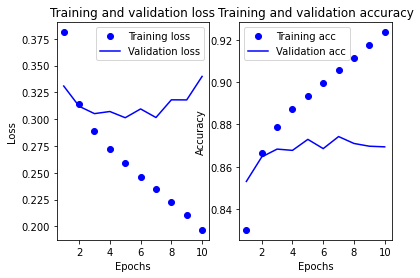

In [23]:
import matplotlib.pyplot as plt

acc_1 = history_dict['accuracy']
val_acc_1 = history_dict['val_accuracy']
loss_1 = history_dict['loss']
val_loss_1 = history_dict['val_loss']

epochs = range(1, len(acc_1) + 1)

plt.subplot(1, 2, 1)

plt.plot(epochs, loss_1, 'bo', label='Training loss')

plt.plot(epochs, val_loss_1, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_1, 'bo', label='Training acc')
plt.plot(epochs, val_acc_1, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

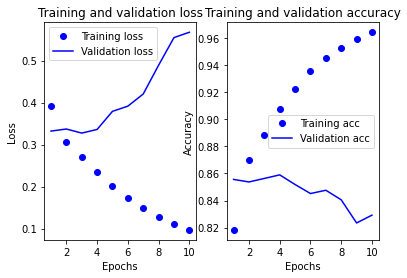

In [24]:
plt.clf()  

acc_2 = history_dict_2['accuracy']
val_acc_2 = history_dict_2['val_accuracy']
loss_2 = history_dict_2['loss']
val_loss_2 = history_dict_2['val_loss']

epochs = range(1, len(acc_2) + 1)

plt.subplot(1, 2, 1)

plt.plot(epochs, loss_2, 'bo', label='Training loss')

plt.plot(epochs, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_2, 'bo', label='Training acc')
plt.plot(epochs, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

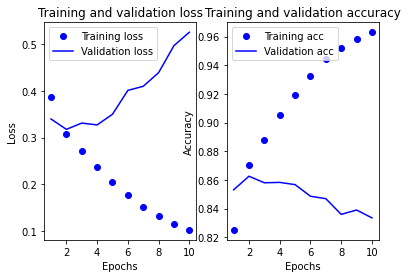

In [25]:
plt.clf()  

acc_3 = history_dict_3['accuracy']
val_acc_3 = history_dict_3['val_accuracy']
loss_3 = history_dict_3['loss']
val_loss_3 = history_dict_3['val_loss']

epochs = range(1, len(acc_3) + 1)

plt.subplot(1, 2, 1)

plt.plot(epochs, loss_3, 'bo', label='Training loss')

plt.plot(epochs, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_3, 'bo', label='Training acc')
plt.plot(epochs, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- LSTM, RNN, CNN 세 가지 모델로 시행해본 결과 LSTM -> CNN -> RNN 순으로 정확도가 높은 것을 확인할 수 있었습니다.
- 시행해본 결과 10 epoch부터는 정확도나 loss 측면에서 validation과 train간의 간격이 벌어지는 것을 확인할 수 있습니다.
    - (이후 부터는 10 epoch만 실행)

## 7) 학습된 Embedding 레이어 분석

### 자체학습한 Embedding

In [26]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [27]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import Word2Vec
word2vec_file_path = '~/aiffel/sentiment_classification/data/word2vec.txt'
my_trained_vector = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path)

In [28]:
my_trained_vector.similar_by_word("꿀")

[('개꿀', 0.9256995916366577),
 ('깊', 0.8812358975410461),
 ('펑펑', 0.8685942888259888),
 ('단연', 0.8629304766654968),
 ('꽤', 0.8583258986473083),
 ('즐겁', 0.8563510775566101),
 ('가슴', 0.8504825830459595),
 ('빕', 0.8492314219474792),
 ('엄청난', 0.8440449833869934),
 ('슬픈', 0.8402259945869446)]

### 사전 학습된 Embedding

In [29]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word2vec_file_path_2 = './data/word2vec_ko.model'
pre_trained_vector = Word2VecKeyedVectors.load(word2vec_file_path_2)
vector = pre_trained_vector.wv.most_similar('꿀')
vector

[('벌꿀', 0.8704620003700256),
 ('호박', 0.8475426435470581),
 ('달걀', 0.83741694688797),
 ('찻잎', 0.8338732123374939),
 ('팥', 0.8337163329124451),
 ('생선', 0.8286590576171875),
 ('된장', 0.8252726197242737),
 ('찹쌀', 0.8228743672370911),
 ('닭', 0.8181455135345459),
 ('국물', 0.8178659081459045)]

In [36]:
pre_trained_vector

In [37]:
my_trained_vector

## 8) 한국어 Word2Vec 임베딩 활용하여 성능 개선
- 한국어 Word2Vec은 /data 폴더 안에 있는 word2vec_ko.model을 활용하세요.
- 한국어 Word2Vec을 활용할 때는 load_word2vec_format() 형태가 아닌 load() 형태로 모델을 불러와주세요. 또한 모델을 활용할 때에는 아래 예시와 같이 .wv를 붙여서 활용합니다. 좀더 자세한 활용법에 대해선 다음 링크들을 참조해주세요.

- https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html#storing-and-loading-models
- https://radimrehurek.com/gensim/models/keyedvectors.html

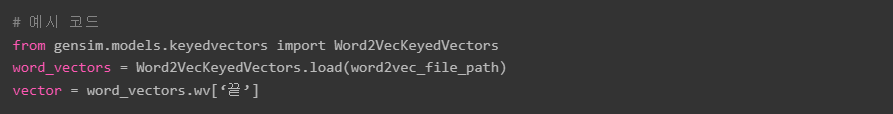

In [41]:
word2vec = Word2VecKeyedVectors.load(word2vec_file_path_2)
vector = word2vec.wv['꿀']
vector.shape 

(100,)

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    
word_vector_dim = 100  

embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피
for i in range(4,vocab_size):
    if index_to_word[i] in word2vec.wv:
        embedding_matrix[i] = word2vec.wv[index_to_word[i]]

In [45]:
from tensorflow.keras.initializers import Constant

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))
model.add(tf.keras.layers.LSTM(hidden_units))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 13s 7ms/step - loss: 0.4188 - accuracy: 0.8043 - val_loss: 0.3956 - val_accuracy: 0.8159
Epoch 2/10
1816/1816 [==============================] - 12s 6ms/step - loss: 0.3183 - accuracy: 0.8616 - val_loss: 0.3259 - val_accuracy: 0.8582
Epoch 3/10
1816/1816 [==============================] - 12s 6ms/step - loss: 0.2807 - accuracy: 0.8813 - val_loss: 0.3137 - val_accuracy: 0.8627
Epoch 4/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2513 - accuracy: 0.8952 - val_loss: 0.3144 - val_accuracy: 0.8673
Epoch 5/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.2240 - accuracy: 0.9089 - val_loss: 0.3336 - val_accuracy: 0.8622
Epoch 6/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1980 - accuracy: 0.9206 - val_loss: 0.3329 - val_accuracy: 0.8672
Epoch 7/10
1816/1816 [==============================] - 11s 6ms/step - loss: 0.1721 - accuracy: 0.9332 - val_loss: 0.3576 - val_ac

In [47]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.4580 - accuracy: 0.8589
[0.4580356776714325, 0.8588807582855225]


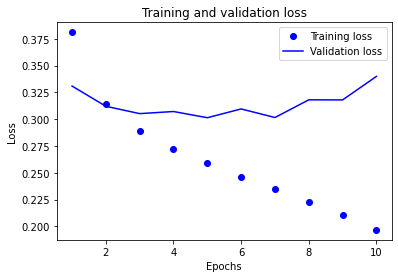

In [48]:
import matplotlib.pyplot as plt

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')

plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

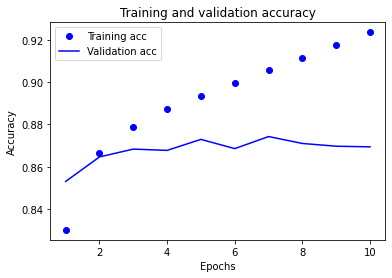

In [49]:
plt.clf() # 그림 초기화

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [50]:
model_2 = tf.keras.Sequential()
model_2.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),  
                                 input_length=maxlen, 
                                 trainable=True))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.MaxPooling1D(5))
model_2.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_2.add(tf.keras.layers.GlobalMaxPooling1D())
model_2.add(tf.keras.layers.Dense(8, activation='relu'))
model_2.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_2.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 16)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [51]:
model_2.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history_2 = model_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 10s 5ms/step - loss: 0.5220 - accuracy: 0.7335 - val_loss: 0.4308 - val_accuracy: 0.8022
Epoch 2/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3970 - accuracy: 0.8209 - val_loss: 0.3979 - val_accuracy: 0.8175
Epoch 3/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3582 - accuracy: 0.8418 - val_loss: 0.3720 - val_accuracy: 0.8323
Epoch 4/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3368 - accuracy: 0.8539 - val_loss: 0.3534 - val_accuracy: 0.8440
Epoch 5/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3218 - accuracy: 0.8616 - val_loss: 0.3555 - val_accuracy: 0.8461
Epoch 6/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3102 - accuracy: 0.8684 - val_loss: 0.3571 - val_accuracy: 0.8477
Epoch 7/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.2997 - accuracy: 0.8733 - val_loss: 0.3633 - val_accuracy

In [53]:
results_2 = model_2.evaluate(X_test,  y_test, verbose=2)

print(results_2)

history_dict_2 = history_2.history

1537/1537 - 3s - loss: 0.3692 - accuracy: 0.8467
[0.36915671825408936, 0.846674919128418]


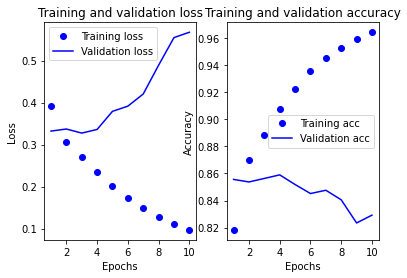

In [52]:
plt.clf()  

acc_2 = history_dict_2['accuracy']
val_acc_2 = history_dict_2['val_accuracy']
loss_2 = history_dict_2['loss']
val_loss_2 = history_dict_2['val_loss']

epochs = range(1, len(acc_2) + 1)

plt.subplot(1, 2, 1)

plt.plot(epochs, loss_2, 'bo', label='Training loss')

plt.plot(epochs, val_loss_2, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_2, 'bo', label='Training acc')
plt.plot(epochs, val_acc_2, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [54]:
model_3 = tf.keras.Sequential()
model_3.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.MaxPooling1D(5))
model_3.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_3.add(tf.keras.layers.GlobalMaxPooling1D())
model_3.add(tf.keras.layers.Dense(8, activation='relu'))
model_3.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_3.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 35, 16)            11216     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 1, 16)             1808      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [55]:
model_3.compile(optimizer='RMSprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10  

history_3 = model_3.fit(partial_X_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
1816/1816 [==============================] - 10s 5ms/step - loss: 0.5398 - accuracy: 0.7167 - val_loss: 0.4412 - val_accuracy: 0.7935
Epoch 2/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3986 - accuracy: 0.8197 - val_loss: 0.3964 - val_accuracy: 0.8202
Epoch 3/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3572 - accuracy: 0.8422 - val_loss: 0.3617 - val_accuracy: 0.8384
Epoch 4/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3355 - accuracy: 0.8537 - val_loss: 0.3483 - val_accuracy: 0.8454
Epoch 5/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3221 - accuracy: 0.8622 - val_loss: 0.3591 - val_accuracy: 0.8487
Epoch 6/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3115 - accuracy: 0.8684 - val_loss: 0.3562 - val_accuracy: 0.8501
Epoch 7/10
1816/1816 [==============================] - 9s 5ms/step - loss: 0.3005 - accuracy: 0.8743 - val_loss: 0.3532 - val_accuracy

In [56]:
results_3 = model_3.evaluate(X_test,  y_test, verbose=2)

print(results_3)

history_dict_3 = history_3.history

1537/1537 - 3s - loss: 0.3686 - accuracy: 0.8487
[0.36861878633499146, 0.8487296104431152]


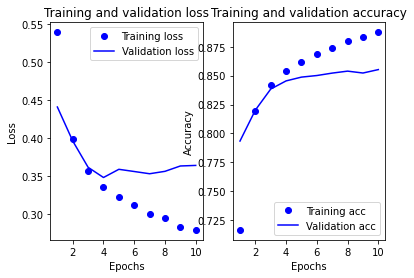

In [57]:
plt.clf()  

acc_3 = history_dict_3['accuracy']
val_acc_3 = history_dict_3['val_accuracy']
loss_3 = history_dict_3['loss']
val_loss_3 = history_dict_3['val_loss']

epochs = range(1, len(acc_3) + 1)

plt.subplot(1, 2, 1)

plt.plot(epochs, loss_3, 'bo', label='Training loss')

plt.plot(epochs, val_loss_3, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, acc_3, 'bo', label='Training acc')
plt.plot(epochs, val_acc_3, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 한국어 한국어 Word2Vec 임베딩를 활용하여 3가지 모델을 개선해 보았다. 결과적으로 LSTM의 경우 소폭 정확도가 감소되었지만 RNN 모델과 CNN 모델의 경우에는 정확도가 개선된 것을 확인할 수 있었다.

## 프로젝트 결과 및 회고
- 이번 프로젝트는 영화 분석 리뷰를 가지고 긍정인지 부정인지 분류하는 프로젝트이다. LSTM, RNN, CNN 세 가지 모델로 진행하였으며 여기에 임베딩 레이어를 추가하여 성능을 개선하고자 하였다.
- 단순히 모델을 구현하여 진행하였을 때에는 LSTM이 가장 높은 성능을 보이는 것을 볼 수 있었으며 임베딩 레이어를 추가하였을 때에는 LSTM 모델은 정확도가 소폭 감소하고 나머지 CNN, RNN 모델을 눈에 띄게 개선되는 것을 확인할 수 있었다.
- 중간과정으로 임베딩 레이어를 만들고 사전 학습된 임베딩 레이어와의 유사 단어를 비교해 보았다. 사전 학습된 임베딩의 경우 좀더 정제된 형태로 유사한 단어가 나오는 것을 확인할 수 있었으며 학습과정에서 만든 임베딩 레이어는 다소 투박한 형태의 단어가 나오는 것을 확인할 수 있었다.